# Phase 4 Project - Sentiment Analysis of Depression in Tweets

![depression_social_media](images/depression_social_media.jpg)

**Name**:  Jordana Tepper  
**Pace**:  Full Time  
**Instructor**: Joseph Mata  

## Overview

This project utilizes a dataset containing various tweets from Twitter to conduct a sentiment analysis for depression. With both mental health disorders and social media use on the constant rise, it is common to see individuals expressing their inner feelings and struggles online. Therefore, this sentiment analysis aims to aid Twitter in classifying certain tweets as potential displays of depression and, as a result, enable the company to use their targeted advertisements to provide mental health resources to the associated users (e.g., showing an advertisement for affordable online therapy). It is significant to note that this project does not act as a diagnostic tool, as depression cannot be formally diagnosed based on tweets. Rather, this sentiment analysis serves as a tool that can be used to detect potential signs of depression and provide support for Twitter users.

Using Natural Language Processing, I implement four different types of models to produce the highest recall score; such models include Random Forest with Count Vectorization, Random Forest with TF-IDF Vectorization, Multinomial Naive Bayes with Count Vectorization, and Multinomial Naive Bayes with TF-IDF Vectorization. Furthermore, each of the four models was subdivided into two, more specific models: one with basic stop words and one with curated stop words.

After reviewing the outputs from each of the models, the highest recall was 98.99%.

I decided to utilize recall as my primary metric because a false negative (classifying a tweet as NOT a potential display of depression when it is) is more costly than a false positive (classifying a tweet as a potential display of depression when it is NOT). In other words, missing an indication of potential depression and not providing the necessary resources can be more harmful than falsely indicating potential depression and providing such resources.

## Business Understanding

As of 2021, approximately 280 million people suffer from depression worldwide [(WHO)](https://www.who.int/news-room/fact-sheets/detail/depression). Furthermore, within the first year of the COVID-19 pandemic, the global prevalence of anxiety and depression increased by 25% [(WHO)](https://www.who.int/news/item/02-03-2022-covid-19-pandemic-triggers-25-increase-in-prevalence-of-anxiety-and-depression-worldwide). In the United States specifically, studies have shown that 1 in 10 Americans suffer from depression [(USA News)](https://www.usnews.com/news/health-news/articles/2022-09-19/depression-affects-almost-1-in-10-americans). With such high rates of mental health disorders - depression, in particular - there is no question that action should be taken to aid individuals in receiving the support and care they need. One way that this can be done is through the utilization of social media. 

According to an analysis from [Kepios](https://datareportal.com/social-media-users#:~:text=Analysis%20from%20Kepios%20shows%20that,of%20the%20total%20global%20population.), over 59% of the world uses social media. Regarding the United States alone, this number rises to 70% [(Pew Research Center)](https://www.pewresearch.org/internet/fact-sheet/social-media/). Therefore, it is no surprise that, often, such areas overlap, and individuals display or provide an indication of their mental health struggles on social media. So, with the abundance of posts and data that social media outlets receive daily, it would be beneficial to society to use such information to detect potential indications of mental health disorders, such as depression, and generate targeted advertisements that provide support and resources for the users who may be in need.

For my project, Twitter is the stakeholder and has asked me to utilize existing tweets from their platform to create a model that detects potential signs of depression through language patterns. Twitter then plans to put this model into practice by distributing mental health resources using the process of targeted advertising.

## Data Understanding

The data that I used for this project comes from a dataset from [Kaggle](https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets) titled "Sentimental Analysis for Tweets." This source is comprised of 10,313 tweets taken from Twitter with each entry classified as either an indication of depression (denoted by 1) or not an indication of depression (denoted by 0).

In [210]:
# Basic Imports
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# NLTK Imports
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.collocations import *

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

In [2]:
# Loading in dataset
df = pd.read_csv('data/sentiment_tweets3.csv')

In [3]:
# Previewing dataset
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1


In [4]:
# Looking at missing values
df.isna().sum()

Index                        0
message to examine           0
label (depression result)    0
dtype: int64

There are no missing values.

In [5]:
# Looking at distribution of target
df['label (depression result)'].value_counts(normalize = True)

0    0.775645
1    0.224355
Name: label (depression result), dtype: float64

The dataset is imbalanced, so I will use SMOTE to fix this.

## Data Preparation

In [6]:
# Dropping last row because the entry is empty as seen from the preview
df = df.drop(10313)

In [7]:
df

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...,...
10308,802308,Many sufferers of depression aren't sad; they ...,1
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [8]:
# Dropping index column
df = df.drop(columns = ['Index'], axis = 1)

In [9]:
df

,message to examine,label (depression result)
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10308,Many sufferers of depression aren't sad; they ...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


In [10]:
# Renaming columns
df = df.rename(columns = {'message to examine':'tweet', 'label (depression result)': 'depression'})

In [11]:
df

,tweet,depression
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
10308,Many sufferers of depression aren't sad; they ...,1
10309,No Depression by G Herbo is my mood from now o...,1
10310,What do you do when depression succumbs the br...,1
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1


### Creating a Stemming and Tokenizing Function

In [13]:
# Defining the stemmer and tokenizer
stemmer = SnowballStemmer(language="english")
stopwords_list = stopwords.words('english')

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [14]:
# Creating a stemming and tokenizing function
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]

In [15]:
# Defining stop words
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

## Data Analysis

### Visualizing Word Frequency

In [119]:
# Make a new X_train for the visualization
tweets = df['tweet'].apply(stem_and_tokenize)

In [120]:
# Creating a stop words removal function
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stemmed_stopwords]
    return stopwords_removed

# Removing stop words
tweets = tweets.apply(remove_stopwords)

In [121]:
# Creating a frequency distribution
freq_dist = FreqDist(tweets.explode())

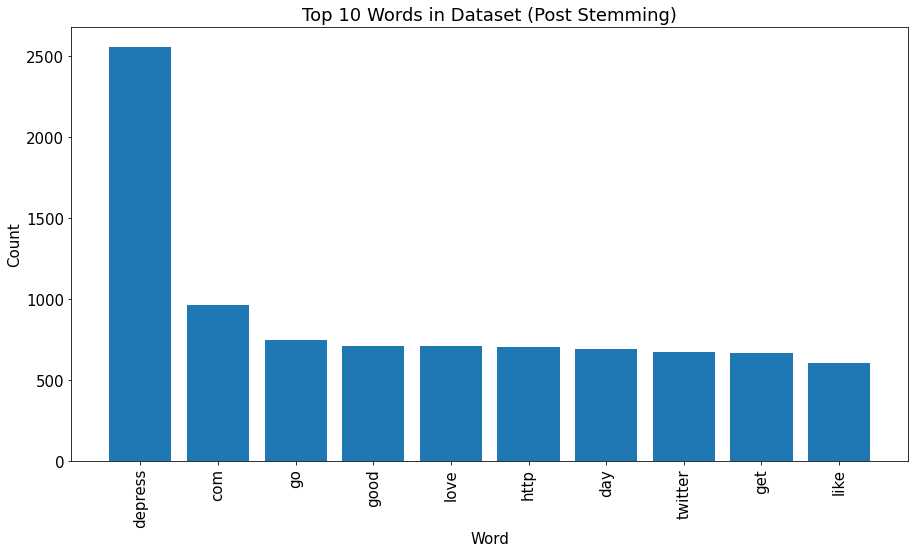

In [122]:
# Finding the top ten words in the training set
top_10 = list(zip(*freq_dist.most_common(10)))
tokens = top_10[0]
counts = top_10[1]

# Plotting the top ten words
fig, ax = plt.subplots(figsize = (15,8))
ax.bar(tokens, counts)

plt.title("Top 10 Words in Dataset (Post Stemming)", fontdict = {'fontsize': 18})
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Word", fontsize = 15)
ax.tick_params(axis="x", rotation=90, labelsize = 15)
ax.tick_params(axis="y", rotation=0, labelsize = 15)
plt.show()

### Examining Bigrams 

In [123]:
# Making a list of the words in the training set
word_list = list(tweets.explode().values)

In [124]:
# Finding the top 20 bigrams in the training set
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(word_list)

finder.apply_freq_filter(3)

finder.nbest(bigram_measures.likelihood_ratio, 20)

[('twitter', 'com'),
 ('pic', 'twitter'),
 ('bit', 'ly'),
 ('http', 'twitpic'),
 ('https', 'www'),
 ('twitpic', 'com'),
 ('http', 'bit'),
 ('https', 'twitter'),
 ('ift', 'tt'),
 ('mental', 'health'),
 ('depress', 'anxieti'),
 ('2018', '04'),
 ('anxieti', 'depress'),
 ('good', 'morn'),
 ('emot', 'intellectu'),
 ('intellectu', 'develop'),
 ('blip', 'fm'),
 ('skin', 'tone'),
 ('tie', 'kid'),
 ('last', 'night')]

In [125]:
# Displaying the top 20 bigrams in order of frequency score
scored = finder.score_ngrams(bigram_measures.raw_freq)
scored[:20]

[(('twitter', 'com'), 0.004331817197314273),
 (('pic', 'twitter'), 0.0029085058324824407),
 (('depress', 'anxieti'), 0.0017120991779861175),
 (('anxieti', 'depress'), 0.0015986468228183627),
 (('https', 'www'), 0.0014129975143620367),
 (('bit', 'ly'), 0.0013614282620130573),
 (('https', 'twitter'), 0.0013408005610734655),
 (('http', 'bit'), 0.001299545159194282),
 (('http', 'twitpic'), 0.0012273482059057107),
 (('twitpic', 'com'), 0.0012273482059057107),
 (('depress', 'https'), 0.0009798157946306093),
 (('good', 'morn'), 0.0008766772899326506),
 (('http', 'www'), 0.0007219695328857123),
 (('mental', 'health'), 0.0006807141310065287),
 (('last', 'night'), 0.0006085171777179575),
 (('cure', 'depress'), 0.0005466340748991821),
 (('feel', 'like'), 0.0005053786730199986),
 (('depress', 'depress'), 0.0004847509720804068),
 (('2018', '04'), 0.00045380942067101913),
 (('https', 'ift'), 0.00045380942067101913)]

After seeing the frequency of terms that do not seem to provide much context to a tweet such as, "http", "https", "com", and "www", I decided that I will make an additional stop words list that includes these terms to see if their removal strengthens or weakens the model.

In [126]:
# Making a copy of the original stop words list
stemmed_stopwords_amended = stemmed_stopwords.copy()

In [127]:
# Adding specific stop words to the amended stop words list
stemmed_stopwords_amended += ['http', 'https', 'com', 'www', 'ly'] 

### Visualizing Word Frequency Post Removal of Amended Stop Words 

In [214]:
# Making a new frequency distribution that omits the added stop words

# Making a new stop word removal function
def remove_stopwords_amended(token_list):
    stopwords_removed = [token for token in token_list if token not in stemmed_stopwords_amended]
    return stopwords_removed

# Removing amended stop words
tweets_amended = tweets.copy()
tweets_amended = tweets_amended.apply(remove_stopwords_amended)

In [215]:
# Creating a frequency distribution
freq_dist_amended = FreqDist(tweets_amended.explode())

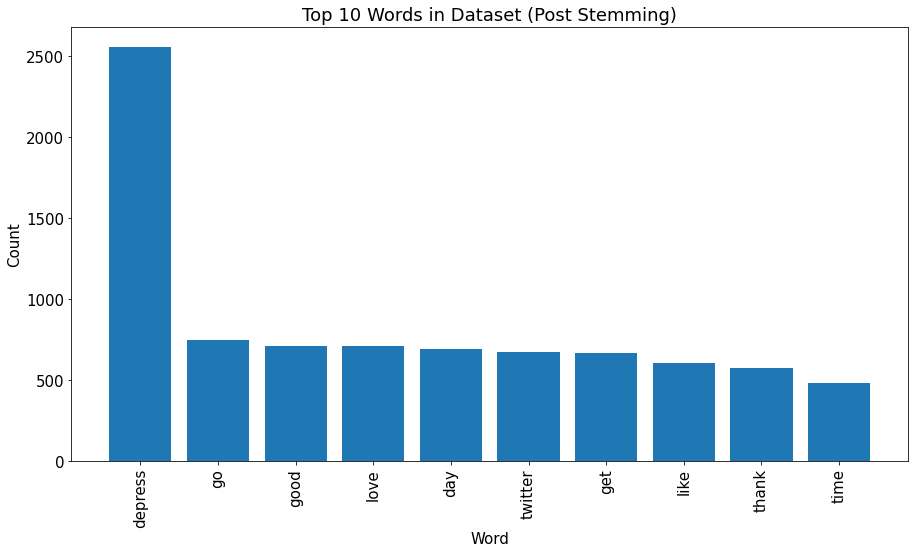

In [216]:
# Finding the top ten words in the training set
top_10 = list(zip(*freq_dist_amended.most_common(10)))
tokens = top_10[0]
counts = top_10[1]

# Plotting the top ten words
fig, ax = plt.subplots(figsize = (15,8))
ax.bar(tokens, counts)

plt.title("Top 10 Words in Dataset (Post Stemming)", fontdict = {'fontsize': 18})
plt.ylabel("Count", fontsize = 15)
plt.xlabel("Word", fontsize = 15)
ax.tick_params(axis="x", rotation=90, labelsize = 15)
ax.tick_params(axis="y", rotation=0, labelsize = 15)
plt.show()

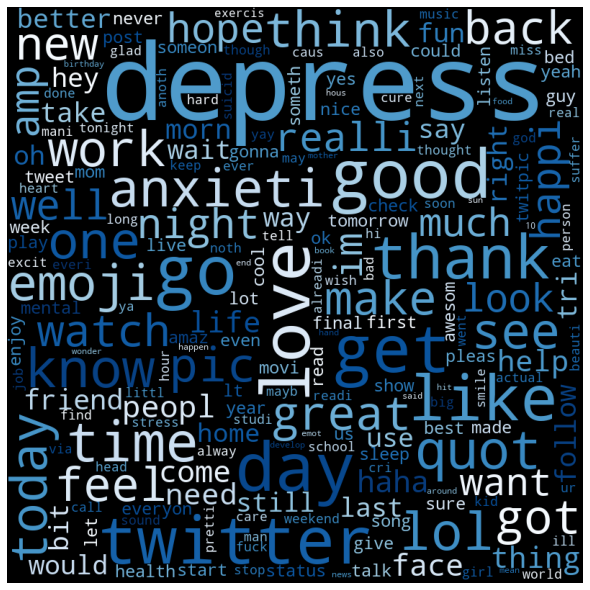

In [264]:
wordcloud = WordCloud(width = 800, height = 800,
                colormap="Blues", background_color ='black',
                min_font_size = 10).generate_from_frequencies(freq_dist_amended)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Modeling

**Due to the fact that the goal of my model is to aid Twitter in targeting those who appear depressed based on their tweets with advertisements about therapy and support, a false negative is more costly than a false positive.**

**Therefore, the metric that matters most in our project is recall.**

**In this project, a false negative is a case where a tweet is classified as NOT being a potential display of depression when it truly is, and a false positive is a case where a tweet is classified as being a potential display of depression when it is not.**

In [128]:
# Train test split
X = df['tweet']
y = df['depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Model 1a: Count Vectorizer and Random Forest (Basic Stemmed Stop Words)

In [129]:
# Defining the pipeline
pipe_rfc_vec_a = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [130]:
# Fitting the pipeline on train data
pipe_rfc_vec_a.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [131]:
# Computing predictions
y_preds_rfc_vec_a = pipe_rfc_vec_a.predict(X_test)

In [132]:
# Calculating the recall score
recall_score(y_test, y_preds_rfc_vec_a)

0.9730639730639731

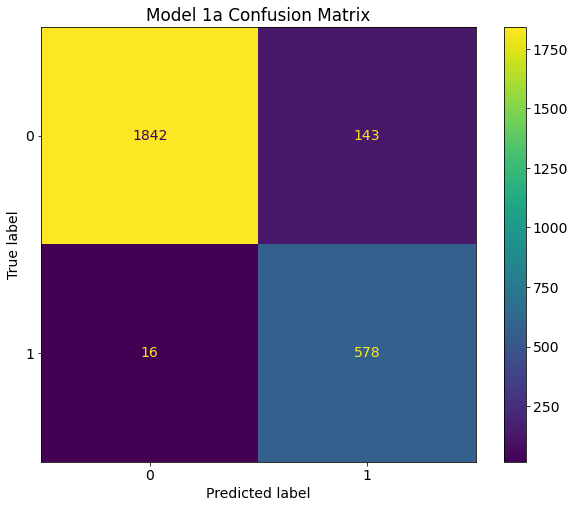

In [133]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 1a Confusion Matrix')
plot_confusion_matrix(pipe_rfc_vec_a, X_test, y_test, ax=ax);

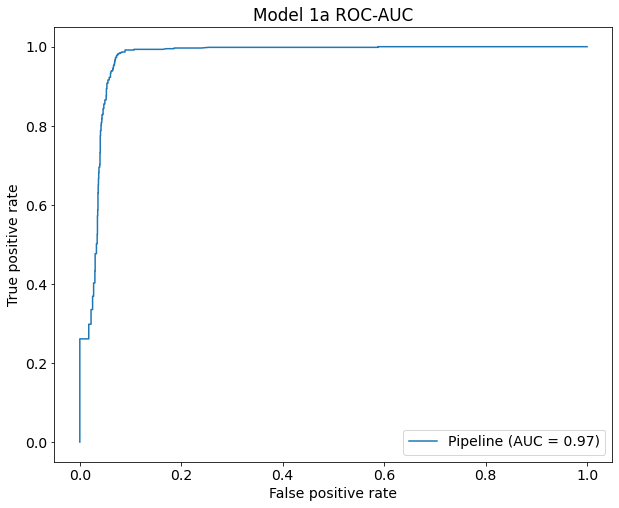

In [134]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_rfc_vec_a, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 1a ROC-AUC')
plt.show()

### Summary of Model 1a:

**Recall Score:** 97.31%  
**False Negatives:** 16  
**False Positives:** 143  
**AUC:** 0.97  

**Notes:** This model is a very good starting point.

### Model 1b: Count Vectorizer and Random Forest (Amended Stemmed Stop Words)

In [135]:
# Defining the pipeline
pipe_rfc_vec_b = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [136]:
# Fitting the pipeline on train data
pipe_rfc_vec_b.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [137]:
# Computing predictions
y_preds_rfc_vec_b = pipe_rfc_vec_b.predict(X_test)

In [138]:
# Calculating the recall score
recall_score(y_test, y_preds_rfc_vec_b)

0.9713804713804713

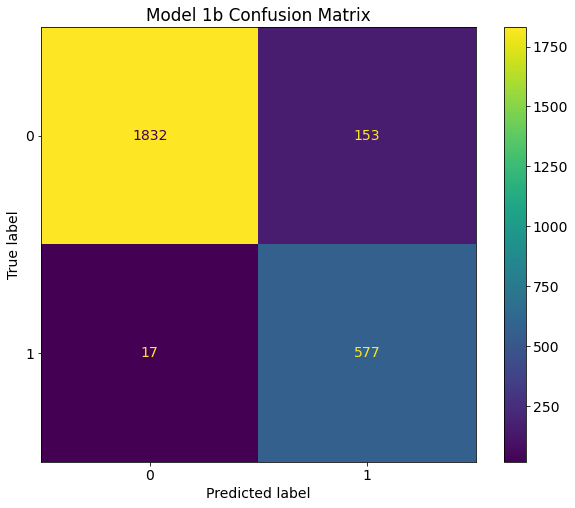

In [139]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 1b Confusion Matrix')
plot_confusion_matrix(pipe_rfc_vec_b, X_test, y_test, ax=ax);

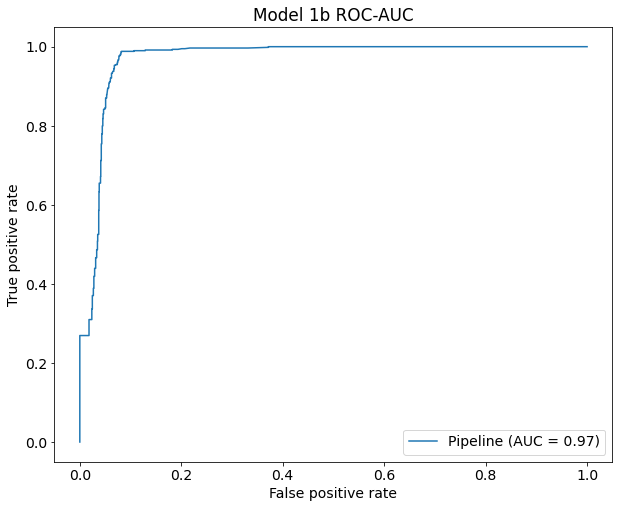

In [140]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_rfc_vec_b, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 1b ROC-AUC')
plt.show()

### Summary of Model 1b:

**Recall Score:** 97.14%  
**False Negatives:** 17  
**False Positives:** 153  
**AUC:** 0.97  

**Notes:** This model is very good, but Model 1a is slightly better.

### Model 2a: TF-IDF Vectorizer and Random Forest (Basic Stemmed Stop Words)

In [141]:
# Defining the pipeline
pipe_rfc_tfidf_a = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [142]:
# Fitting the pipeline on train data
pipe_rfc_tfidf_a.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [143]:
# Computing predictions
y_preds_rfc_tfidf_a = pipe_rfc_tfidf_a.predict(X_test)

In [144]:
# Calculating the recall score
recall_score(y_test, y_preds_rfc_tfidf_a)

0.9865319865319865

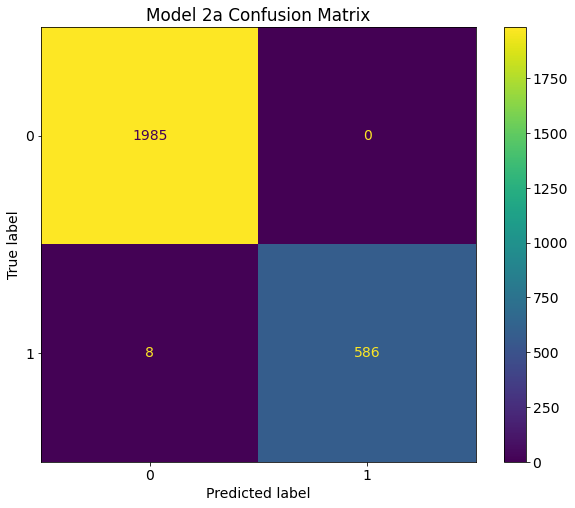

In [145]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 2a Confusion Matrix')
plot_confusion_matrix(pipe_rfc_tfidf_a, X_test, y_test, ax=ax);

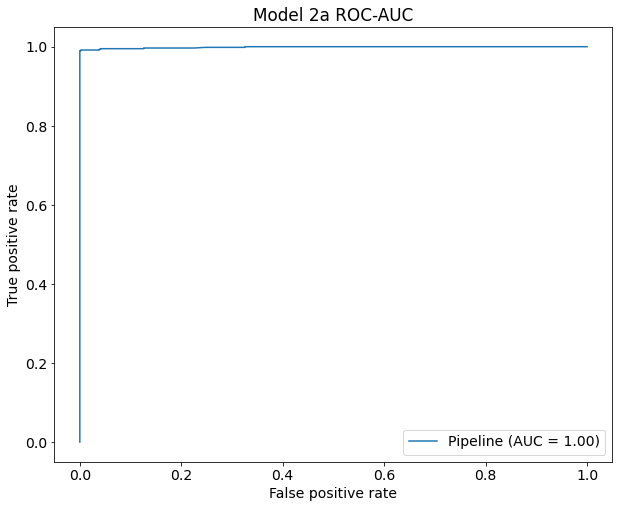

In [146]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_rfc_tfidf_a, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 2a ROC-AUC')
plt.show()

### Summary of Model 2a:

**Recall Score:** 98.65%  
**False Negatives:** 8  
**False Positives:** 0  
**AUC:** 1.00  

**Notes:** So far, this is the best model.

### Model 2b: TF-IDF Vectorizer and Random Forest (Amended Stemmed Stop Words)

In [147]:
# Defining the pipeline
pipe_rfc_tfidf_b = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('rfc', RandomForestClassifier(random_state = 42))
])

In [148]:
# Fitting the pipeline on train data
pipe_rfc_tfidf_b.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)),
                ('rfc', RandomForestClassifier(random_state=42))])

In [149]:
# Computing predictions
y_preds_rfc_tfidf_b = pipe_rfc_tfidf_b.predict(X_test)

In [150]:
# Calculating the recall score
recall_score(y_test, y_preds_rfc_tfidf_b)

0.9848484848484849

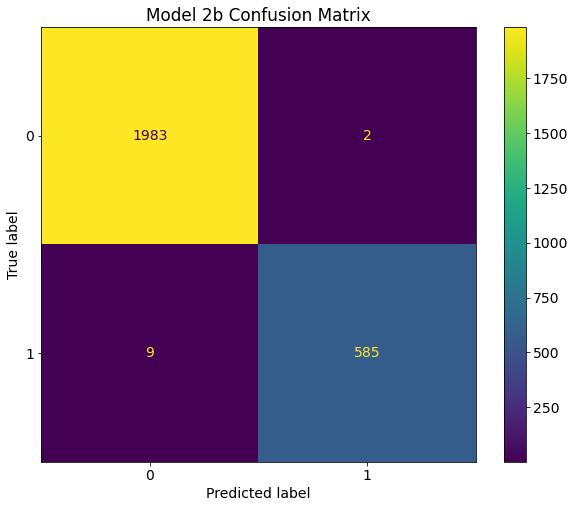

In [151]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 2b Confusion Matrix')
plot_confusion_matrix(pipe_rfc_tfidf_b, X_test, y_test, ax=ax);

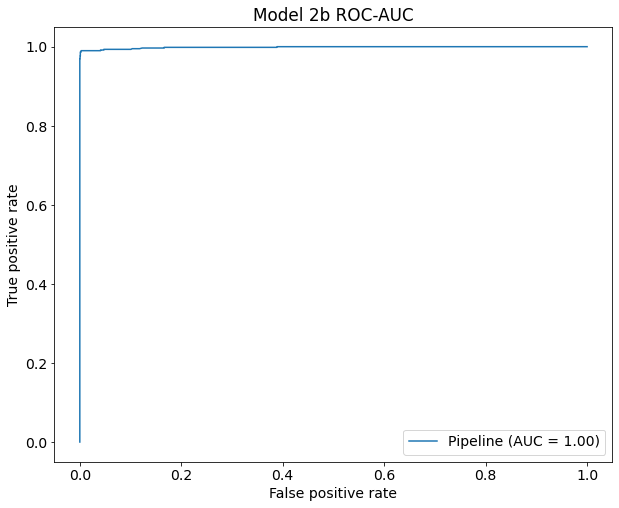

In [152]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_rfc_tfidf_b, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 2b ROC-AUC')
plt.show()

### Summary of Model 2b:

**Recall Score:** 98.48%  
**False Negatives:** 9  
**False Positives:** 2  
**AUC:** 1.00  

**Notes:** This is another really good model, but it does not surpass Model 2a.

### Model 3a: Count Vectorizer and Multinomial Naive Bayes (Basic Stemmed Stop Words)

In [153]:
# Defining the pipeline
pipe_mnb_vec_a = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [154]:
# Fitting the pipeline on train data
pipe_mnb_vec_a.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [155]:
# Computing predictions
y_preds_mnb_vec_a = pipe_mnb_vec_a.predict(X_test)

In [156]:
# Calculating the recall score
recall_score(y_test, y_preds_mnb_vec_a)

0.98989898989899

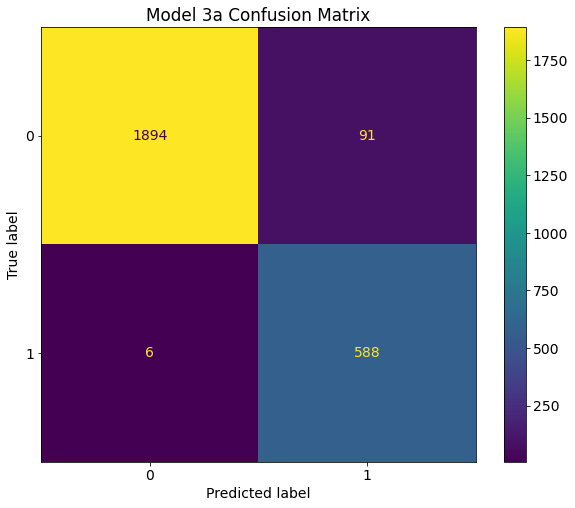

In [157]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 3a Confusion Matrix')
plot_confusion_matrix(pipe_mnb_vec_a, X_test, y_test, ax=ax);

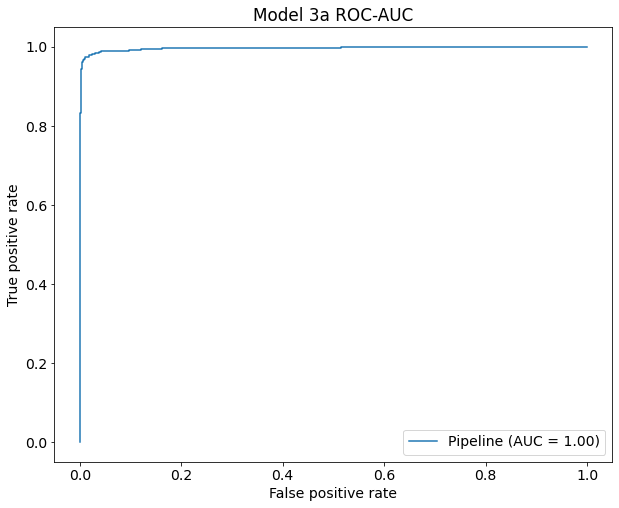

In [158]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_mnb_vec_a, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 3a ROC-AUC')
plt.show()

### Summary of Model 3a:

**Recall Score:** 98.99%  
**False Negatives:** 6  
**False Positives:** 91  
**AUC:** 1.00  

**Notes:** In regard to recall score, this model is the best.

### Model 3b: Count Vectorizer and Multinomial Naive Bayes (Amended Stemmed Stop Words)

In [159]:
# Defining the pipeline
pipe_mnb_vec_b = Pipeline([
  ('vect', CountVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [160]:
# Fitting the pipeline on the train data
pipe_mnb_vec_b.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [161]:
# Computing predictions
y_preds_mnb_vec_b = pipe_mnb_vec_b.predict(X_test)

In [162]:
# Calculating the recall score
recall_score(y_test, y_preds_mnb_vec_b)

0.9865319865319865

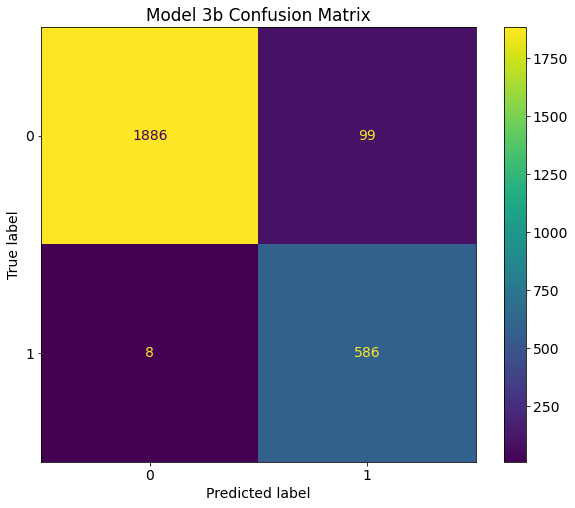

In [163]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 3b Confusion Matrix')
plot_confusion_matrix(pipe_mnb_vec_b, X_test, y_test, ax=ax);

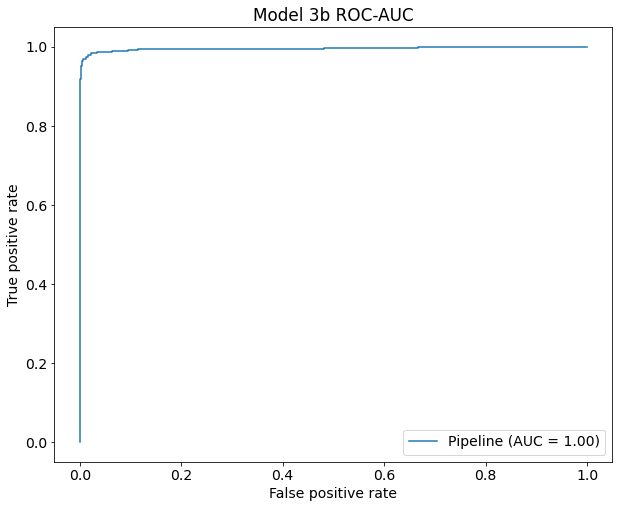

In [164]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_mnb_vec_b, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 3b ROC-AUC')
plt.show()

### Summary of Model 3b:

**Recall Score:** 98.65%  
**False Negatives:** 8  
**False Positives:** 99  
**AUC:** 1.00 

**Notes:** The results of this model are very good, but Model 3a is better.

### Model 4a: TF-IDF and Multinomial Naive Bayes (Basic Stemmed Stop Words)

In [165]:
# Defining the pipeline
pipe_mnb_tfidc_a = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [166]:
# Fitting the pipeline
pipe_mnb_tfidc_a.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [167]:
# Computing predictions
y_preds_mnb_tfidf_a = pipe_mnb_tfidc_a.predict(X_test)

In [168]:
# Calculating the recall score
recall_score(y_test, y_preds_mnb_tfidf_a)

0.9848484848484849

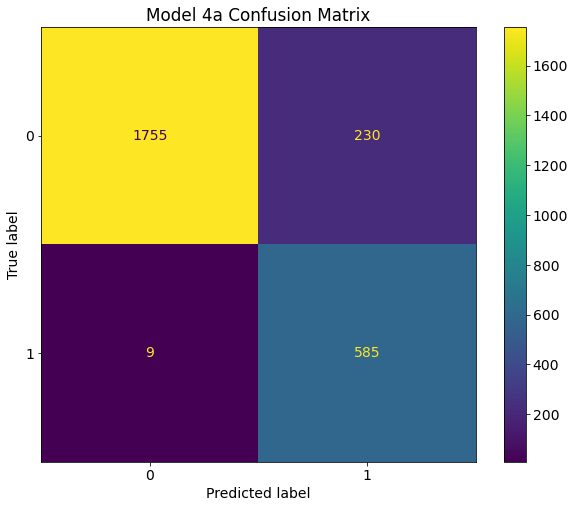

In [169]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 4a Confusion Matrix')
plot_confusion_matrix(pipe_mnb_tfidc_a, X_test, y_test, ax=ax);

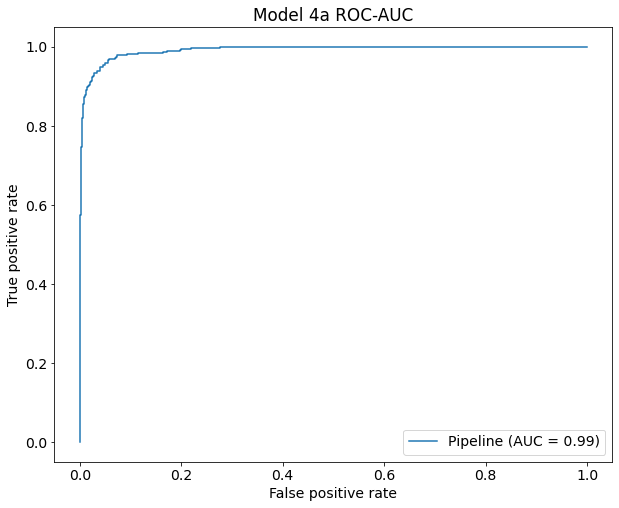

In [170]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_mnb_tfidc_a, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 4a ROC-AUC')
plt.show()

### Summary of Model 4a:

**Recall Score:** 98.48%  
**False Negatives:** 9  
**False Positives:** 230  
**AUC:** 0.99 

**Notes:** Similar to past models, the results of this model are great, but Model 3a still has the strongest performance.

### Model 4b: TF-IDF and Multinomial Naive Bayes (Amended Stemmed Stop Words)

In [171]:
# Defining the pipeline
pipe_mnb_tfidc_b = Pipeline([
  ('tfidf', TfidfVectorizer(stop_words=stemmed_stopwords_amended, tokenizer=stem_and_tokenize)),
   ('smote', SMOTE(random_state=42)),
   ('mnb', MultinomialNB())
])

In [172]:
# Fitting the pipeline on the train data
pipe_mnb_tfidc_b.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             "you'r", "you'v", "you'll",
                                             "you'd", 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'his', 'himself', 'she',
                                             'she', 'her', 'her', 'herself',
                                             'it', 'it', 'it', 'itself', ...],
                                 tokenizer=<function stem_and_tokenize at 0x7f88416b70d0>)),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [173]:
# Computing predictions
y_preds_mnb_tfidf_b = pipe_mnb_tfidc_b.predict(X_test)

In [174]:
# Calculating the recall score
recall_score(y_test, y_preds_mnb_tfidf_b)

0.9831649831649831

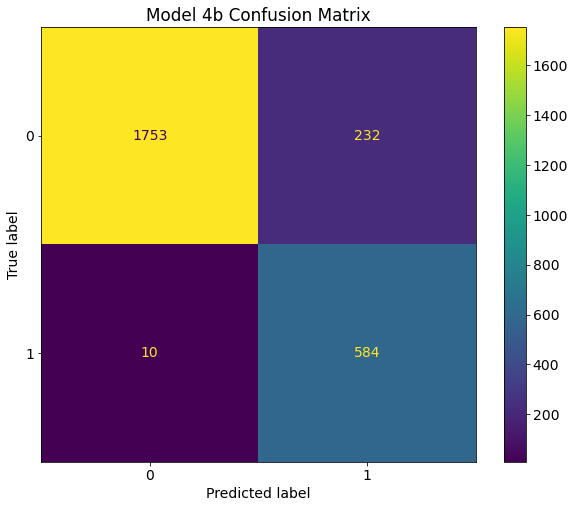

In [175]:
# Creating a confusion matrix
fig, ax = plt.subplots(figsize = (10, 8))
plt.rcParams.update({'font.size': 14})
ax.set_title('Model 4b Confusion Matrix')
plot_confusion_matrix(pipe_mnb_tfidc_b, X_test, y_test, ax=ax);

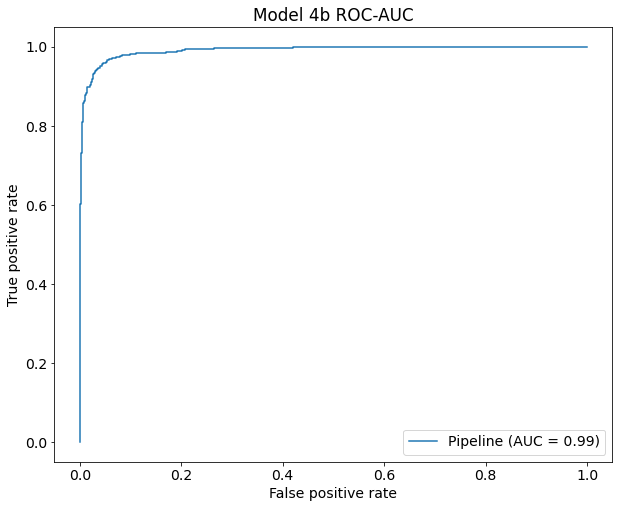

In [176]:
# Visualizing the AUC (Area Under the Curve)
fig, ax = plt.subplots(figsize = (10,8))
plot_roc_curve(pipe_mnb_tfidc_b, X_test, y_test, ax = ax)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.set_title('Model 4b ROC-AUC')
plt.show()

### Summary of Model 4b:

**Recall Score:** 98.32%  
**False Negatives:** 10  
**False Positives:** 232  
**AUC:** 0.99 

**Notes:** Another really great model, but the results are weaker than those of Model 3a.

## Evaluation

Based on recall scores (and confusion matrices), the two best models are Model 3a and Model 2a. Model 3a has a recall score of 98.99%, and Model 2a has a recall score of 98.65%. Although Model 3b also has a recall score of 98.65%, Model 2a has a better overall confusion matrix (8 false negatives and 0 false positives).

### Comparing Sample Data Using the Two Best Models: Model 2a and Model 3a

In [177]:
sample_1 = ['I am depressed']

In [178]:
print(pipe_rfc_tfidf_a.predict(sample_1))
print(pipe_mnb_vec_a.predict(sample_1))

[1]
[1]


In [179]:
sample_2 = ['I want to die']

In [180]:
print(pipe_rfc_tfidf_a.predict(sample_2)) # Flawed
print(pipe_mnb_vec_a.predict(sample_2))

[0]
[1]


In [181]:
sample_3 = ['Kill me']

In [182]:
print(pipe_rfc_tfidf_a.predict(sample_3)) # Flawed
print(pipe_mnb_vec_a.predict(sample_3))

[0]
[1]


In [183]:
sample_4 = ['I want to kill myself']

In [184]:
print(pipe_rfc_tfidf_a.predict(sample_4)) # Flawed
print(pipe_mnb_vec_a.predict(sample_4)) # Flawed

[0]
[0]


In [188]:
sample_5 = ['i am depressed'] # Testing capitalization

In [189]:
print(pipe_rfc_tfidf_a.predict(sample_5))
print(pipe_mnb_vec_a.predict(sample_5))

[1]
[1]


In [190]:
sample_6 = ['I am not depressed']

In [191]:
print(pipe_rfc_tfidf_a.predict(sample_6)) # Flawed
print(pipe_mnb_vec_a.predict(sample_6)) # Flawed

[1]
[1]


In [192]:
sample_7 = ['I need help']

In [193]:
print(pipe_rfc_tfidf_a.predict(sample_7)) # Flawed
print(pipe_mnb_vec_a.predict(sample_7))

[0]
[1]


In [194]:
sample_8 = ['My dog is so cute']

In [195]:
print(pipe_rfc_tfidf_a.predict(sample_8))
print(pipe_mnb_vec_a.predict(sample_8))

[0]
[0]


In [196]:
sample_9 = ['I need a good new show to watch']

In [197]:
print(pipe_rfc_tfidf_a.predict(sample_9))
print(pipe_mnb_vec_a.predict(sample_9))

[0]
[0]


In [198]:
sample_10 = ['School is so stressful']

In [199]:
print(pipe_rfc_tfidf_a.predict(sample_10)) #Flawed
print(pipe_mnb_vec_a.predict(sample_10))

[0]
[1]


In [200]:
sample_11 = ["I'm so hungry, what should I eat?"]

In [201]:
print(pipe_rfc_tfidf_a.predict(sample_11))
print(pipe_mnb_vec_a.predict(sample_11))

[0]
[0]


In [202]:
sample_12 = ['Procrasinating doing my homework']

In [203]:
print(pipe_rfc_tfidf_a.predict(sample_12))
print(pipe_mnb_vec_a.predict(sample_12))

[0]
[0]


In [204]:
sample_13 = ['I am depro']

In [205]:
print(pipe_rfc_tfidf_a.predict(sample_13)) #Flawed
print(pipe_mnb_vec_a.predict(sample_13)) # Flawd

[0]
[0]


In [206]:
sample_14 = ['I am emo']

In [207]:
print(pipe_rfc_tfidf_a.predict(sample_14)) # Flawed
print(pipe_mnb_vec_a.predict(sample_14)) # Flawed

[0]
[0]


#### Thoughts:

With recall being the primary metric, the best models are Models 2a and 3a. More specifically, Model 2a has a recall of 98.65% (8 false negatives) and Model 3a has a recall of 98.99% (6 false negatives). Despite Model 3a having 2 fewer false negatives, I contemplated making my final model Model 2a rather than Model 3a due to the fact that it has no false positives while Model 3a has 91 false positives. In other words, Model 2a minimizes both false negatives and false positives. Furthermore, there is not much difference in the recall percentages of the two models, and a difference of 2 false negatives does not seem too significant. Nevertheless, after doing some sample tweets, I decided that my final model is Model 3a. While both models were flawed with some of the sample tweets, the specific examples that led me to this decision are "I want to die", "Kill me", and "I need help." If anyone were to see these tweets, they would likely believe that the user is potentially struggling with depression or other mental health concerns, so when Model 2a did not pick up on such patterns, I decided that Model 3a is better. 

## Preparing for Deployment of Model

### Pickling Model 3a

In [208]:
import pickle
with open("model3a.pkl", "wb") as f:
    pickle.dump(pipe_mnb_vec_a, f)

## Deployed Model

https://jordanate-sentiment-analysis-phase-4-project-model-0ki2uu.streamlit.app/

## Conclusions

### Recommendations

### Limitations

- The model fails to understand slang words such as 'emo' and 'depro'
- The model also fails to properly interpret negation in statements such as, "I am NOT depressed" or "I am NOT okay"
- These two limitations likely root from the fact that this dataset contains only 10,313 tweets meaning that the model cannot capture every pattern of text and language that exists online.

### Next Steps

If I had access to more data, I would do the following:

- Acquire a larger dataset
- Acquire more data that accounts for slang words
- Develop models that incorporates other languages

## Mental Health Resources

**United States Suicide and Crisis Lifeline (24/7):** Call 988 (No data charges)  

**NAMI HelpLine (M-F, 10am - 10pm, ET):** Call 1-800-950-NAMI (6264), Text "HelpLine" to 62640, or Email at **<a href="mailto:helpline@nami.org">helpline@nami.org</a>**

**SAMHSA’s (Substance Abuse and Mental Health Services Administration) National Helpline (24/7):** Call 1-800-662-HELP (4357) 

**Crisis Text Line (24/7):** Text HOME to 741741

**BetterHelp Teletherapy:** **https://www.betterhelp.com/**